The Sparks Foundation

Exploratory Data Analysis - Task 7- Stock Market Prediction using Numerical and Textual Analysis (Level - Advanced)

### Author:Jayasree Vemula


In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [5]:

!pip3 install statsmodels

In [6]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import norm
import statsmodels.api as sm

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [8]:

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
! pip3 install textblob
from textblob import TextBlob

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip3 install lightgbm
import lightgbm

In [11]:
!pip3 install pmdarima

     |████████████████████████████████| 1.5MB 25.8MB/s 
     |████████████████████████████████| 9.5MB 36.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [13]:
from google.colab import files
uploaded = files.upload()
import io
df_prices = pd.read_csv(io.BytesIO(uploaded['^BSESN.csv']))
df_prices.head()

Saving ^BSESN.csv to ^BSESN.csv


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0


In [14]:
len(df_prices)

252

In [15]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Open       250 non-null    float64       
 2   High       250 non-null    float64       
 3   Low        250 non-null    float64       
 4   Close      250 non-null    float64       
 5   Adj Close  250 non-null    float64       
 6   Volume     250 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.9 KB


In [16]:
df_prices.dropna(inplace = True)
print(len(df_prices))

250


Text(0, 0.5, 'BSESN')

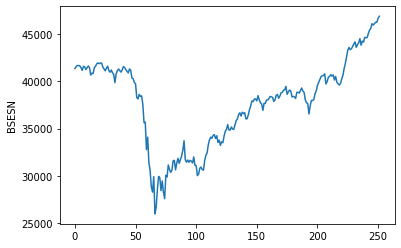

In [17]:
df_prices['Close'].plot()
plt.ylabel('BSESN')

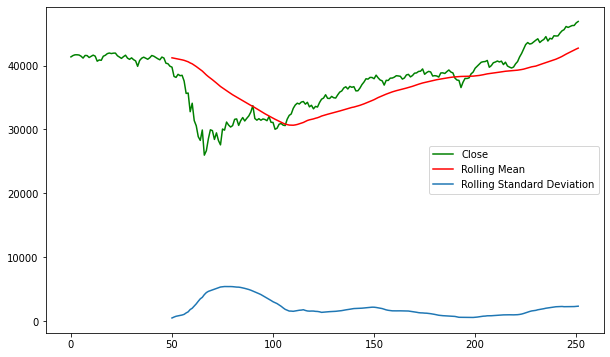

In [18]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'g', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

In [19]:
# Train test Split

train = df_prices[:3000]
test = df_prices[3000:]

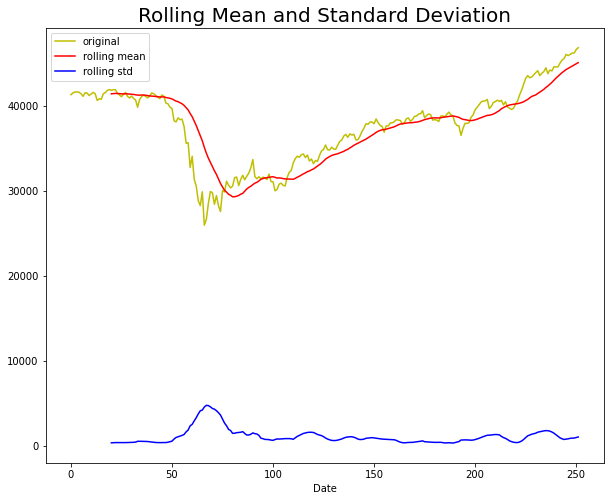

Results of dickey fuller test
ADF Test Statistic : -0.6982850827498309
p-value : 0.8471932401708802
#Lags Used : 6
Number of Observations Used : 243
Weak evidence against null hypothesis, time series is non-stationary 


In [20]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

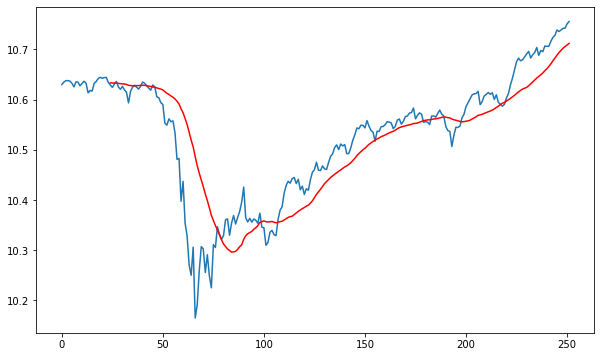

In [21]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

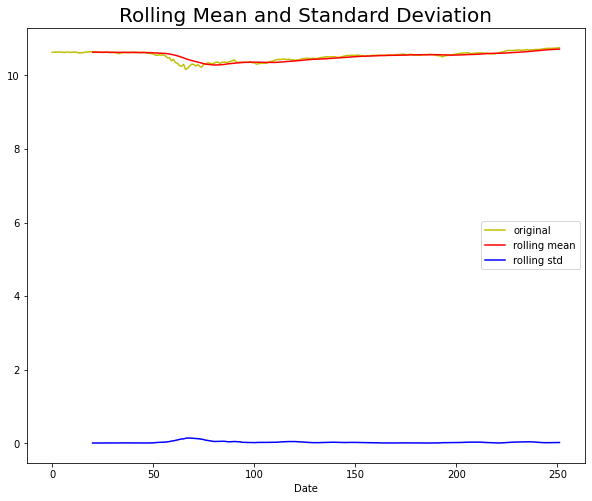

Results of dickey fuller test
ADF Test Statistic : -1.1857021490482853
p-value : 0.6797158478016483
#Lags Used : 7
Number of Observations Used : 242
Weak evidence against null hypothesis, time series is non-stationary 


In [22]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

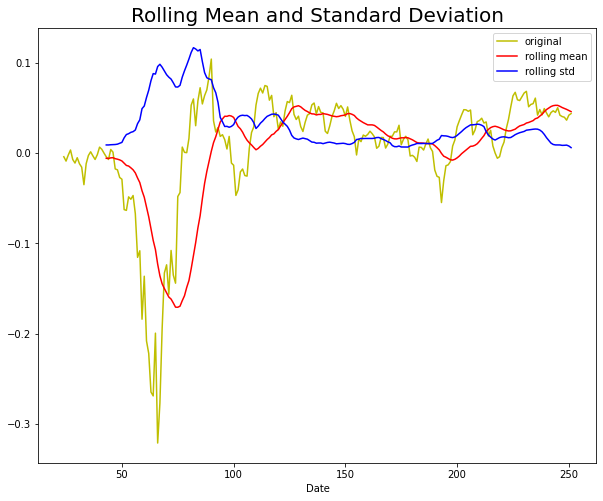

Results of dickey fuller test
ADF Test Statistic : -3.0188108043276234
p-value : 0.03317466037433193
#Lags Used : 7
Number of Observations Used : 219
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [23]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

**Time series Prediction**

In [24]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1229.180, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1228.630, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1231.551, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1230.976, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1230.477, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1230.063, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1229.768, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1232.322, Time=0.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1228.479, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1233.522, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1230.635, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1233.470, Time=0.71 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1231.040, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1233.250, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0

ValueError: ignored

# **Textual Analysis**

In [30]:
from google.colab import files
uploaded = files.upload()
cols = ['Date','Category','News']


Saving india-news-headlines.csv to india-news-headlines.csv


KeyError: ignored

In [32]:
df_news=pd.read_csv(io.BytesIO(uploaded['india-news-headlines.csv']),names = cols,engine='python', error_bad_lines=False)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3424063,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,20201231,removed,Govt extends deadline for use of FASTag till F...


In [33]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 78.4+ MB


In [34]:
pd.to_datetime(df_news.iloc[:,0].str.replace('‑','-'),format='%Y%m%d')

1         2001-01-02
2         2001-01-02
3         2001-01-02
4         2001-01-02
5         2001-01-02
             ...    
3424063   2020-12-31
3424064   2020-12-31
3424065   2020-12-31
3424066   2020-12-31
3424067   2020-12-31
Name: Date, Length: 3424067, dtype: datetime64[ns]

In [35]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],errors='coerce', format= '%Y%M%d')
df_news

,Date,News
1,2001-01-02 00:01:00,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02 00:01:00,Fissures in Hurriyat over Pak visit
3,2001-01-02 00:01:00,America's unwanted heading for India?
4,2001-01-02 00:01:00,For bigwigs; it is destination Goa
5,2001-01-02 00:01:00,Extra buses to clear tourist traffic
...,...,...
3424063,2020-01-31 00:12:00,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-01-31 00:12:00,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-01-31 00:12:00,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,2020-01-31 00:12:00,Govt extends deadline for use of FASTag till F...


In [36]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02 00:01:00,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03 00:01:00,Powerless north India gropes in the dark Think...
2,2001-01-04 00:01:00,The string that pulled Stephen Hawking to Indi...
3,2001-01-05 00:01:00,Light combat craft takes India into club class...
4,2001-01-06 00:01:00,Light combat craft takes India into club class...
...,...,...
7257,2020-01-27 00:12:00,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-01-28 00:12:00,Horoscope Today; 28 December 2020: Check astro...
7259,2020-01-29 00:12:00,Man recovers charred remains of 'thief' from h...
7260,2020-01-30 00:12:00,Numerology Readings 30 December 2020: Predicti...


In [37]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

In [ ]:

#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

In [ ]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive


In [ ]:
exog_data = df_merge[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral','Positive']]
exog_data

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive


In [ ]:
df_time_series = df_merge['Close']

In [ ]:
df_time_series

Series([], Name: Close, dtype: float64)

In [ ]:
final_train_data = df_time_series[:3000]
exog_train_data = exog_data[:3000]

final_test_data = df_time_series[3000:]
exog_test_data = exog_data[3000:]